## Part 4: Experiments with the Tensorflow and CIFAR Dataset
#### Convolutional Neural Network Model

### Reference:
1. https://www.tensorflow.org/get_started/mnist/beginners
2. https://www.tensorflow.org/get_started/mnist/pros
3. https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/tutorials/mnist
4. http://web.stanford.edu/class/cs20si/
5. https://github.com/Hvass-Labs/TensorFlow-Tutorials
6. https://www.oreilly.com/learning/not-another-mnist-tutorial-with-tensorflow
7. https://github.com/martin-gorner/tensorflow-mnist-tutorial
8. https://github.com/aymericdamien/TensorFlow-Examples
9. http://yann.lecun.com/exdb/mnist/
10. http://www.aimechanic.com/2016/10/13/d242-tensorflow-cifar-10-tutorial-detailed-step-by-step-review-part-1/
11. https://www.cs.toronto.edu/~kriz/cifar.html

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import time
from datetime import timedelta
import math
import random
import os
import re
from sklearn import preprocessing
%matplotlib inline

In [40]:
#Function for reading CIFAR Data
def  unpickle(file):
    fo = open(file, 'rb')
    data = pickle.load(fo, encoding = 'bytes')
    return data

In [41]:
xtrain = []
xftrain = []
ytrain = []
for i in range(1,6):
    file = 'cifar/data_batch_' + str(i)
    u = unpickle(file)
    x = u[b'data'].reshape(10000,3,32,32).transpose(0,2,3,1).astype('float')
    xf = u[b'data'].astype('float')
    y = np.array(u[b'labels'])
    xtrain.append(x)
    xftrain.append(xf)
    ytrain.append(y)

    
xtrain = np.concatenate(xtrain)    
xftrain = np.concatenate(xftrain)    
ytrain = np.concatenate(ytrain)


enc = preprocessing.OneHotEncoder()
enc.fit(ytrain.reshape(-1,1))
y_encoded = enc.transform(ytrain.reshape(-1,1)).toarray()

In [42]:
# Data Exploration:
# Image Data
print("Training Image Shape/Size:", np.shape(xtrain))
print("Training Labels Shape/Size:", np.shape(ytrain))

Training Image Shape/Size: (50000, 32, 32, 3)
Training Labels Shape/Size: (50000,)


In [43]:
xtest = []
xftest = []
ytest = []
file = 'cifar/test_batch'
k = unpickle(file)
xtest = k[b'data'].reshape(10000,3,32,32).transpose(0,2,3,1).astype('float')
xftest = k[b'data'].astype('float')
ytest = np.array(k[b'labels'])

enc = preprocessing.OneHotEncoder()
enc.fit(ytest.reshape(-1,1))
y_test_encoded = enc.transform(np.array(k[b'labels']).reshape(-1,1)).toarray()

In [44]:
#Test set:
print("Test Image Shape/Size:", np.shape(xtest))
print("Test Labels Shape/Size:", np.shape(ytest))

Test Image Shape/Size: (10000, 32, 32, 3)
Test Labels Shape/Size: (10000,)


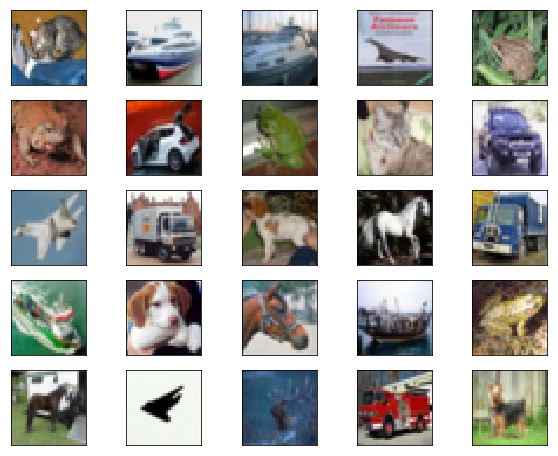

In [45]:
#Plotting a visualization of the images.
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default plot sizes
fig, axes = plt.subplots(5,5)
for i, ax in enumerate(axes.flat):
    ax.imshow(xtest[i].astype('uint8'))
    ax.set_xticks([])
    ax.set_yticks([])

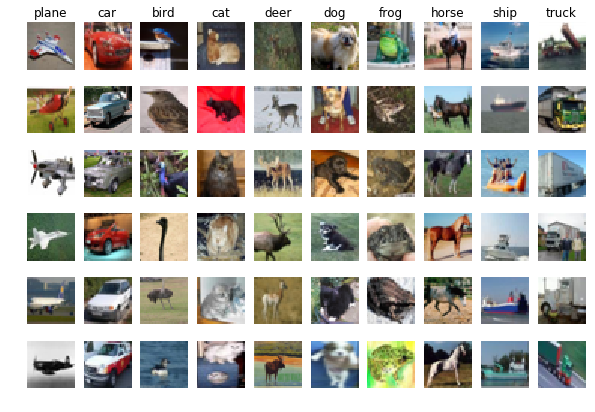

In [46]:
#Plotting larger images with interpolation and their correct classes:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default plot sizes
plt.rcParams['image.interpolation']  = 'nearest' # User nearest neighbor for rendering small size images.
#Visualize some of the classes
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
number_of_samples = 7
number_of_classes = len(classes)

for idx, name in enumerate(classes):
    y_sample = np.where(ytrain == idx) #Get the array of sample numbers that belong to one particular class
    y_idx = y_sample[0][1:number_of_samples] #Store the array numbers of first 'n' samples
    
    #Plot samples of a particular class
    for i,j in enumerate(y_idx):
        #subplot manages the plotting parameters
        # The third argument is used so that each image is rendered at an offset.
        plt.subplot(number_of_samples,number_of_classes, i*number_of_classes + idx +1)
        plt.imshow(xtrain[j].astype('uint8'))
        plt.axis('off')
        if(i == 0):
            plt.title(name)
plt.show()

In [47]:
#Setting up constant values
img_height = 32
img_width = 32
num_channels = 3
img_flat = img_height * img_width * num_channels
img_shape = (img_height, img_width)
num_classes = 10

In [48]:
def new_weights(shape):
    return(tf.Variable(tf.truncated_normal(shape, stddev = 0.05)))

In [49]:
def new_biases(length):
    return(tf.Variable(tf.constant(0.05, shape = [length])))

In [50]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling = True):
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape = shape)
    biases = new_biases(length = num_filters)
    
    layer = tf.nn.conv2d(input = input, filter = weights, strides = [1,1,1,1], padding = 'SAME')
    layer = layer + biases
    
    layer = tf.nn.max_pool(value = layer, ksize = [1,3,3,1], strides = [1,2,2,1], padding = 'SAME')
    layer = tf.nn.lrn(layer,4, bias = 1.0, alpha = 0.001/9.0, beta = 0.75)
    layer = tf.nn.relu(layer)
    
    return(layer, weights)

In [51]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return(layer_flat, num_features)

In [52]:
def new_fc_layer(input, num_inputs, num_outputs, use_relu = True):
    weights = new_weights(shape = [num_inputs, num_outputs])
    biases = new_biases(length = num_outputs)
    layer = tf.matmul(input, weights) + biases
    layer = tf.nn.relu(layer)
    return(layer)

In [53]:
filter_size1 = 5
num_filters1 = 64

filter_size2 = 5
num_filters2 = 64

fc1_size = 128
fc2_size = 128

In [54]:
x = tf.placeholder(tf.float32, shape = [None, img_flat], name = 'x')
x_image = tf.reshape(x, [-1, img_width, img_height, num_channels])
y_true = tf.placeholder(tf.float32, shape = [None, num_classes],name = 'y_true')
y_true_class = tf.argmax(y_true, dimension = 1)
layer_conv1, weights_conv1 = new_conv_layer(input = x_image,
                                           num_input_channels = num_channels,
                                           filter_size = filter_size1,
                                           num_filters = num_filters1,
                                           use_pooling = True)
layer_conv1
layer_conv2, weights_conv2 = new_conv_layer(input = layer_conv1, num_input_channels = num_filters1,
                                           filter_size = filter_size2,
                                           num_filters = num_filters2,
                                           use_pooling = True)
layer_conv2

<tf.Tensor 'Relu_9:0' shape=(?, 8, 8, 64) dtype=float32>

In [55]:
layer_flat, num_features = flatten_layer(layer_conv2)
layer_flat
layer_fc1 = new_fc_layer(input = layer_flat, num_inputs = num_features, num_outputs = fc1_size)
layer_fc1
layer_fc2 = new_fc_layer(input = layer_fc1, num_inputs = fc2_size, num_outputs = num_classes)
layer_fc2

<tf.Tensor 'Relu_11:0' shape=(?, 10) dtype=float32>

In [56]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_class = tf.argmax(y_pred, dimension = 1)

In [57]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = layer_fc2, labels = y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_class ,  y_true_class)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
session = tf.Session()
session.run(tf.global_variables_initializer())

In [58]:
train_batch_size = 128

In [59]:
#Function to generate batches
offset = 0

In [60]:
def generate_batches(batchsize):
    global offset
    if(offset > len(xf)):
        offset = 0;
    xf_offset = xftrain[offset:offset + batchsize][:]
    y_offset = y_encoded[offset: offset + batchsize]
    offset = offset + batchsize
    return(xf_offset, y_offset)

In [67]:
total_iterations = 0 

def optimize(num_iterations):
    global total_iterations
    
    start_time = time.time()
    for i in range(total_iterations, total_iterations + num_iterations):
        x_batch, y_true_batch = generate_batches(train_batch_size)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        writer = tf.summary.FileWriter('./Part4_CIFAR', session.graph)
        session.run(optimizer, feed_dict = feed_dict_train)
        if i % 100 == 0:
            #print(y_pred_class)
            #yop = session.run(y_pred_class, feed_dict = feed_dict_train)
            #print(yop)
            acc = session.run(accuracy, feed_dict= feed_dict_train)
            msg = "Optimization Iteration : {0:>6}, Training Accuracy : {1:>6.1%}"
            print(msg.format(i, acc))
    writer.close()
    total_iterations = total_iterations + num_iterations
    end_time = time.time()
    time_diff = end_time = start_time
    #print("Time: " + str(timedelta(seconds = int(round(time_diff)))))
    print("Time: ", time_diff)

In [64]:
test_batch_size = 128

def print_test_accuracy():
    num_test = len(xftest)
    class_pred = np.zeros(shape = num_test, dtype = np.int)
    i = 0
    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = xftest[i:j, :]
        #yhash = hash(tuple(y_test_encoded[i:j]))
        labels = y_test_encoded[i:j,:]
        feed_dict = {x: images,y_true: labels}
        class_pred[i:j] = session.run(y_pred_class, feed_dict = feed_dict)
        i = j
    
    print("Pred Results", class_pred[:])
    print("Pred Results", ytest[0:25])
    class_true = ytest
    correct = (class_true == class_pred)
    cm = confusion_matrix(y_true = class_true, y_pred = class_pred)
    print("Confusion Matrix")
    print(cm)
    
    correct_sum = correct.sum()
    
    acc = float(correct_sum) / num_test
    msg = "Accuracy on Test Set : {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    

In [66]:
optimize(num_iterations = 400)

Optimization Iteration :      1, Training Accuracy :  14.1%
Optimization Iteration :    101, Training Accuracy :   7.0%
Optimization Iteration :    201, Training Accuracy :  11.7%
Optimization Iteration :    301, Training Accuracy :  14.1%
Time:  1496889308.8052619


In [68]:
print_test_accuracy()

Pred Results [0 0 0 ..., 0 0 0]
Pred Results [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
Confusion Matrix
[[1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]]
Accuracy on Test Set : 10.0% (1000 / 10000)
